# Import

In [56]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import randrange, uniform
from scipy.stats import norm
import math
import copy
import os

from botorch.test_functions import Ackley
from botorch.test_functions import Beale
from botorch.test_functions import Branin
from botorch.test_functions import EggHolder
from botorch.test_functions import Hartmann
from botorch.test_functions import Levy
from botorch.test_functions import Griewank
from botorch.test_functions import Powell
from botorch.test_functions import Shekel
from botorch.test_functions import Rosenbrock
from botorch.test_functions import StyblinskiTang

In [57]:
import torch

from scipy.optimize import minimize, brute
from scipy.stats import norm

In [58]:
from botorch.test_functions import Ackley
from botorch.test_functions import Beale
from botorch.test_functions import Branin
from botorch.test_functions import EggHolder
from botorch.test_functions import Hartmann

from botorch.test_functions import synthetic
from __future__ import annotations
import math
from typing import List, Optional, Tuple
import torch
from botorch.test_functions.base import BaseTestProblem
from torch import Tensor

class Sincos(synthetic.SyntheticTestFunction):  #fstar=0.15985376279886299+0.26  negate=True  0.15985376310215924

    dim = 1
    _bounds = [(-1., 2.)]
    _check_grad_at_opt = False

    def evaluate_true(self, X: Tensor) -> Tensor:

        fval =X*torch.sin(X)+X*torch.cos(2*X)-0.26

        return fval

class  Fourier(synthetic.SyntheticTestFunction):  #fstar=1.22+9.50835043776628 negate=True

    dim = 1
    _bounds = [(0., 10.)]
    _check_grad_at_opt = False

    def evaluate_true(self, X: Tensor) -> Tensor:

        fval = X*torch.sin(X)+X*torch.cos(2*X)-1.22

        return fval
    

class  Sincos2d(synthetic.SyntheticTestFunction):  #fstar=1.0310741691325334 negate=False

    dim = 2
    _bounds = [(0., 6.),(0.,6.)]
    _check_grad_at_opt = False

    def evaluate_true(self, X: Tensor) -> Tensor:
        
        u = X[:,0]-3
        v = (X[:,1]-3) /2
        
        fval = np.sin(u)*np.cos(v)*np.cos(u*v/2)+np.sin(u*v/5)

        return fval

# Define my Function

In [59]:
class GP_ObjectiveFunction:  
    def __init__(self,dim=2,lengthscale=1.2,variance=10,seed=0):
      self.dim = dim
      self.lengthscale = lengthscale
      self.variance = variance
      self.bounds = np.array([[0,6]]*dim)
      self.init_num = 8**dim

      np.random.seed(seed) 

      X_start = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1],size=(1,dim))
      temp = float(np.random.normal(0, 1, size=1))
      Y_start=np.array([[temp]])

      kernel = GPy.kern.RBF(input_dim=dim,variance=variance,lengthscale=lengthscale)
      m_start = GPy.models.GPRegression(X_start,Y_start,kernel)
      m_start.Gaussian_noise.variance.fix(0.0)

      X_init = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1],size=(self.init_num ,dim))
      Y_init = m_start.posterior_samples_f(X_init.reshape(-1,dim),size=1)

      kernel = GPy.kern.RBF(input_dim=dim,variance=variance,lengthscale=lengthscale)
      m_init = GPy.models.GPRegression(X_init.reshape(-1,dim),Y_init.reshape(-1,1),kernel)
      m_init.Gaussian_noise.variance.fix(0.0)

      self.GP = m_init

      X_check_max = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1],size=((5100+900**dim),dim))
      mean_check_max,_ = self.GP.predict(X_check_max.reshape(-1,self.dim),include_likelihood=False)
      max = np.max(mean_check_max)
      self.max = max

    def __call__(self, X):

        mean,_ = self.GP.predict(X.reshape(-1,self.dim),include_likelihood=False)

        return mean

In [88]:
def EI(X,dim,f_best,model): # X is a 2-dimensional array because we will use it in scipy.minimize

  #model_temp = copy.deepcopy(model)
  X = X.reshape(-1,dim)

  mean,var = model.predict(X,include_likelihood=False)
  
  var[var<10**(-12)]=10**(-12)

  z = (mean - f_best)/np.sqrt(var)        
  out=(mean - f_best) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)

  return out.ravel()  #make the shape to be 1 dimensional



def EI_acquisition_opt(model,bounds,f_best): #bound should an array of size dim*2
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}
  restart_num = dim #int(max(dim-1,1))
  
  size = 25
  X_candidate = []
  AF_candidate = []
  
  init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(size*dim*restart_num, dim))

  for i in range(size*dim*restart_num):
    # init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    # value_holder = EI(init_X,dim,f_best,model)
      
    # x0=init_X[np.argmax(value_holder)]

    x0 = init_X[i]

    res = minimize(lambda x: -EI(X=x,dim=dim,f_best=f_best,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B  nelder-mead(better for rough function) Powell

    X_temp =   np.round(res.x,decimals=4)      #res.x  
    AF_temp = EI(X=np.array(X_temp).reshape(-1,1),dim=dim,f_best=f_best,model=model)
    
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next

In [61]:
def TEI(X,dim,f_best,f_star,model): # X is a 2-dimensional array because we will use it in scipy.minimize

  #model_temp = copy.deepcopy(model)
  X = X.reshape(-1,dim)

  mean,var = model.predict(X,include_likelihood=False)
  
  var[var<10**(-12)]=10**(-12)

  z = (mean - f_best)/np.sqrt(var)        
  out=(mean - f_best) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)
  
  z_truncated = (mean - f_star)/np.sqrt(var)        
  out_truncated=(mean - f_star) * norm.cdf(z_truncated) + np.sqrt(var) * norm.pdf(z_truncated)
  
  res = out - out_truncated

  return res.ravel()  #make the shape to be 1 dimensional



def TEI_acquisition_opt(model,bounds,f_best,f_star,gradient_method=False): #bound should an array of size dim*2
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}
  restart_num = int(max(dim-1,1))
  
  X_candidate = []
  AF_candidate = []

  for i in range(restart_num):
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    value_holder = TEI(init_X,dim,f_best,f_star,model)
      
    x0=init_X[np.argmax(value_holder)]

    res = minimize(lambda x: -TEI(X=x,dim=dim,f_best=f_best,f_star=f_star,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B  nelder-mead(better for rough function) Powell

    X_temp =   np.round(res.x,decimals=4)      #res.x  
    AF_temp = TEI(X=np.array(X_temp).reshape(-1,1),dim=dim,f_best=f_best,f_star=f_star,model=model)
    
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next

In [100]:
def MES(X,dim,fstar,model): # X is a 2-dimensional array because we will use it in scipy.minimize
  
  X = X.reshape(-1,dim)
  mean,var = model.predict(X,include_likelihood=False)

  var[var<10**(-12)]=10**(-12)
  gamma = (fstar-mean)/np.sqrt(var)  

  cdf_part = norm.cdf(gamma)
  #print(cdf_part)
  #cdf_part[cdf_part<10**(-300)]=10**(-300)

  out = (gamma*norm.pdf(gamma))/(2*cdf_part)-np.log(cdf_part)

  return out.ravel() 



def MES_acquisition_opt(model,bounds,fstar): #bound should an array of size dim*2

  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}
  restart_num = dim #int(max(dim-1,1))
  
  size = 15
  X_candidate = []
  AF_candidate = []
  
  init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(size*dim*restart_num, dim))

  for i in range(size*dim*restart_num):
    # init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    # value_holder = MES(init_X,dim,fstar,model)
        
    # x0=init_X[np.argmax(value_holder)]
    
    x0 = init_X[i]


    res = minimize(lambda x: -MES(X=x,dim=dim,fstar=fstar,model=model),x0,
                                  bounds=bounds,method="nelder-mead",options=opts) #L-BFGS-B nelder-mead(better for rough function) Powell

    X_temp =  np.round(res.x,decimals=4)  #res.x
    AF_temp = MES(X=np.array(X_temp).reshape(-1,1),dim=dim,fstar=fstar,model=model)
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]


  return X_next

In [63]:
def FindMax(X,dim,fstar,model): # X is a 2-dimensional array because we will use it in scipy.minimize
  
  X = X.reshape(-1,dim)
  mean,var = model.predict(X,include_likelihood=False)

  var[var<10**(-12)]=10**(-12)
  gamma = (fstar-mean)/np.sqrt(var)  

  out = norm.pdf(gamma)

  return out.ravel() 

def FindMax_acquisition_opt(model,bounds,fstar): #bound should an array of size dim*2
  
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}
  restart_num = dim #int(max(dim-1,1))
  
  size = 10
  X_candidate = []
  AF_candidate = []
  
  init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(size*dim*restart_num, dim))


  for i in range(size*dim*restart_num):
    # init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    # value_holder = FindMax(init_X,dim,fstar,model)
        
    # x0=init_X[np.argmax(value_holder)]

    x0 = init_X[i]
    res = minimize(lambda x: -FindMax(X=x,dim=dim,fstar=fstar,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B nelder-mead(better for rough function) Powell

    X_temp = np.round(res.x,decimals=4)   #res.x
    AF_temp = FindMax(X=np.array(X_temp).reshape(-1,1),dim=dim,fstar=fstar,model=model)
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)


    

  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next

In [74]:
def high_dimensional_discretization(bounds,N=800): #bounds shoud always be two dimensional, N is the number of partition in one dimension

  dim = bounds.shape[0]


  bounds = bounds.reshape(dim,-1)
  coords = [np.linspace(bounds[d][0], bounds[d][1], N) for d in range(dim)]
  mesh = np.meshgrid(*coords, indexing='ij')

  coords = np.vstack([x.flatten() for x in mesh]).T

  return coords

In [105]:
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
from scipy import ndimage

def PI_max(X_temp,research_length,fstar,model_fantasy,bounds): # X is a 2-dimensional array because we will use it in scipy.minimize
    
  ########################## local search ############################  
  dim = bounds.shape[0]

  if dim == 1:
    N = 800
  elif dim ==2:
    N = 50
  elif dim ==3:
    N = 14  #2744
  elif dim == 4:
    N = 9  #6561
  elif dim == 5:
    N = 6 # 7776
  elif dim ==6:
    N = 5 #15625


  if research_length == 0: 
    res = 0

  else:
      
    lower_before = X_temp-research_length 
    upper_before = X_temp+research_length

    lower_after = np.maximum(lower_before,bounds[:,0]).reshape(-1)
    upper_after = np.minimum(upper_before,bounds[:,1]).reshape(-1)

    new_bounds = np.array([lower_after.tolist(),upper_after.tolist()]).T  #make sure the bounds are two-dimensional

    # print(new_bounds)
    # print('shape:',new_bounds.shape)

    if len(new_bounds.shape) != 2:     # dimension check
      print('check your bounds dimension!')  

    X = high_dimensional_discretization(new_bounds,N=N)    # shape is (-1,dim)
    X = X.reshape(-1,dim)
    mean,var = model_fantasy.predict(X,include_likelihood=False)
    #var[var<10**(-12)]=10**(-12)
    z = (mean-fstar)/np.sqrt(var)

    PI_holder = norm.cdf(z)
    res = np.max(PI_holder)

  return res 


def PO(X,research_length,dim,fstar,model,bounds,train_x,train_obj): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)
  mean,var = model.predict(X,include_likelihood=False)
  #var[var<10**(-12)]=10**(-12)
  gamma = (fstar-mean)/np.sqrt(var)  
  P_max = norm.pdf(gamma)

  PNI_holder = []


  model_fantasy = model.copy() 

  for X_temp in X:

    #print("X_temp is:",X_temp)


    new_X = X_temp.reshape(-1,dim)
    new_Y = np.array([[fstar]]) 
    train_x_fantasy = np.concatenate((train_x, new_X))
    train_obj_fantasy = np.concatenate((train_obj, new_Y))

    model_fantasy.set_XY(X=train_x_fantasy.reshape(-1,dim), Y=train_obj_fantasy.reshape(-1,1))

    #model_fantasy = model.condition_on_observations(X=new_X, Y=new_Y,noise=noise.expand_as(new_Y))
    PI = PI_max(X_temp=new_X,research_length=research_length,fstar=fstar,model_fantasy=model_fantasy,bounds=bounds)


    PNI_holder.append(1-PI)



  return  (np.array(PNI_holder).reshape(-1,1)*P_max).ravel()



def PO_acquisition_opt(model,bounds,fstar,research_length,train_x,train_obj): # new 

  # dim = bounds.shape[0]
  # opts_fm ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}
  # opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}
  # restart_num = int(max(dim-1,1))
  
    
  # X_candidate = []
  # AF_candidate = []
  
  # X_candidate_temp = []
  
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}
  restart_num = dim #int(max(dim-1,1))
  size = 25
  

  X_candidate = []
  AF_candidate = []
  X_candidate_temp = []
  init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(size*dim*restart_num, dim))
    

  # for i in range(restart_num):
    
  #   init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
  #   # start by FindMax
  #   value_holder = FindMax(init_X,dim,fstar,model)
  #   x0=init_X[np.argmax(value_holder)]
  #   res_temp = minimize(lambda x: -FindMax(X=x,dim=dim,fstar=fstar,model=model),x0,
  #                                 bounds=bounds,method="L-BFGS-B",options=opts_fm) #L-BFGS-B nelder-mead(better for rough function) Powell
  #   x0_FindMax =  np.round(res_temp.x,decimals=4).tolist()
  #   X_candidate_temp.append(x0_FindMax)
  #   ######################################################
    
  # init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(15*dim, dim))
  for x0_temp in init_X:
    res_temp = minimize(lambda x: -FindMax(X=x,dim=dim,fstar=fstar,model=model),x0_temp,
                                  bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B nelder-mead(better for rough function) Powell
    
    x0_FindMax = np.round(res_temp.x,decimals=4).tolist()
    X_candidate_temp.append(x0_FindMax)
    
    res_temp2 = minimize(lambda x: FindMax(X=x,dim=dim,fstar=fstar,model=model),x0_temp,
                              bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B nelder-mead(better for rough function) Powell
    
    x0_FindMax_min = np.round(res_temp2.x,decimals=4).tolist()
    if FindMax(X=np.round(res_temp2.x,decimals=4),dim=dim,fstar=fstar,model=model)>0.00001:
      X_candidate_temp.append(x0_FindMax_min)
    
      
    
  unique_list = list({tuple(x): None for x in X_candidate_temp}.keys())
  X_candidate_unique = [list(x) for x in unique_list]
  
  if dim <= 3:
    for x0 in X_candidate_unique:
      x0 = np.array(x0)     
      res = minimize(lambda x: -PO(X=x,research_length=research_length,dim=dim,fstar=fstar,model=model,bounds=bounds,train_x=train_x,train_obj=train_obj),x0,
                                    bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B  nelder-mead(better for rough functions) Powell
      
      X_temp= np.round(res.x,decimals=4) 
      AF_temp = PO(X=np.array(X_temp).reshape(-1,1),research_length=research_length,dim=dim,fstar=fstar,model=model,bounds=bounds,train_x=train_x,train_obj=train_obj)
      X_candidate.append(X_temp)
      AF_candidate.append(AF_temp)
      
  else: 
    for x0 in X_candidate_unique:
      x0 = np.array(x0)  
      X_temp= np.round(x0,decimals=4) 
      AF_temp = PO(X=np.array(X_temp).reshape(-1,1),research_length=research_length,dim=dim,fstar=fstar,model=model,bounds=bounds,train_x=train_x,train_obj=train_obj)
      X_candidate.append(X_temp)
      AF_candidate.append(AF_temp)
      

  print('length of AF candidates are: ', len(AF_candidate))
  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next

In [67]:
# Mixed method!!!
def PI_max(X_temp,research_length,fstar,model_fantasy,bounds): # X is a 2-dimensional array because we will use it in scipy.minimize
    
  ########################## local search ############################  
  dim = bounds.shape[0]


  if dim == 1:
    N = 800
  elif dim ==2:
    N = 50
  elif dim ==3:
    N = 14  #2744
  elif dim == 4:
    N = 9  #6561
  elif dim == 5:
    N = 6 # 7776
  elif dim ==6:
    N = 5 #15625



  if research_length == 0: 
    res = 0

  else:
      
    lower_before = X_temp-research_length 
    upper_before = X_temp+research_length

    lower_after = np.maximum(lower_before,bounds[:,0]).reshape(-1)
    upper_after = np.minimum(upper_before,bounds[:,1]).reshape(-1)

    new_bounds = np.array([lower_after.tolist(),upper_after.tolist()]).T  #make sure the bounds are two-dimensional

    # print(new_bounds)
    # print('shape:',new_bounds.shape)

    if len(new_bounds.shape) != 2:     # dimension check
      print('check your bounds dimension!')  

    X = high_dimensional_discretization(new_bounds,N=N)    # shape is (-1,dim)
    X = X.reshape(-1,dim)
    mean,var = model_fantasy.predict(X,include_likelihood=False)
    #var[var<10**(-12)]=10**(-12)
    z = (mean-fstar)/np.sqrt(var)

    PI_holder = norm.cdf(z)
    res = np.max(PI_holder)

  return res 


def Mixed(X,research_length,dim,fstar,model,bounds,train_x,train_obj): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)
  P_max = MES(X,dim,fstar,model).reshape(-1,1) #just than the first part

  PNI_holder = []


  model_fantasy = model.copy() 

  for X_temp in X:

    #print("X_temp is:",X_temp)


    new_X = X_temp.reshape(-1,dim)
    new_Y = np.array([[fstar]]) 
    train_x_fantasy = np.concatenate((train_x, new_X))
    train_obj_fantasy = np.concatenate((train_obj, new_Y))

    model_fantasy.set_XY(X=train_x_fantasy.reshape(-1,dim), Y=train_obj_fantasy.reshape(-1,1))

    #model_fantasy = model.condition_on_observations(X=new_X, Y=new_Y,noise=noise.expand_as(new_Y))
    PI = PI_max(X_temp=new_X,research_length=research_length,fstar=fstar,model_fantasy=model_fantasy,bounds=bounds)


    PNI_holder.append(1-PI)



  return  (np.array(PNI_holder).reshape(-1,1)*P_max).ravel()


def Mixed_acquisition_opt(model,bounds,fstar,research_length,train_x,train_obj): # new 

  dim = bounds.shape[0]
  opts_fm ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}
  restart_num = int(max(dim-1,1))
  
    
  X_candidate = []
  AF_candidate = []
  
  X_candidate_temp = []
    

  for i in range(restart_num):
    
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    # start by FindMax
    value_holder = MES(init_X,dim,fstar,model)
    x0=init_X[np.argmax(value_holder)]
    res_temp = minimize(lambda x: -MES(X=x,dim=dim,fstar=fstar,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts_fm) #L-BFGS-B nelder-mead(better for rough function) Powell
    x0_FindMax =  np.round(res_temp.x,decimals=4).tolist()
    X_candidate_temp.append(x0_FindMax)
    ######################################################
    
  init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(15*dim, dim))
  for x0_temp in init_X:
    res_temp = minimize(lambda x: -MES(X=x,dim=dim,fstar=fstar,model=model),x0_temp,
                                  bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B nelder-mead(better for rough function) Powell
    
    x0_FindMax = np.round(res_temp.x,decimals=4).tolist()
    X_candidate_temp.append(x0_FindMax)
      
    
  unique_list = list({tuple(x): None for x in X_candidate_temp}.keys())
  X_candidate_unique = [list(x) for x in unique_list]
  
  if dim <= 3:
    for x0 in X_candidate_unique:
      x0 = np.array(x0)     
      res = minimize(lambda x: -Mixed(X=x,research_length=research_length,dim=dim,fstar=fstar,model=model,bounds=bounds,train_x=train_x,train_obj=train_obj),x0,
                                    bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B  nelder-mead(better for rough functions) Powell
      
      X_temp= np.round(res.x,decimals=4) 
      AF_temp = Mixed(X=np.array(X_temp).reshape(-1,1),research_length=research_length,dim=dim,fstar=fstar,model=model,bounds=bounds,train_x=train_x,train_obj=train_obj)
      X_candidate.append(X_temp)
      AF_candidate.append(AF_temp)
      
  else: 
    for x0 in X_candidate_unique:
      x0 = np.array(x0)  
      X_temp= np.round(x0,decimals=4) 
      AF_temp = Mixed(X=np.array(X_temp).reshape(-1,1),research_length=research_length,dim=dim,fstar=fstar,model=model,bounds=bounds,train_x=train_x,train_obj=train_obj)
      X_candidate.append(X_temp)
      AF_candidate.append(AF_temp)
      

  print('length of AF candidates are: ', len(AF_candidate))
  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next

In [80]:
def Grid_EI_acquisition_opt(model,bounds,f_best,gradient_method=False): #bound should an array of size dim*2
  
  dim = bounds.shape[0]
  
  if dim == 1:
    N = 800
  elif dim == 2:
    N = 42
  
  X_total = high_dimensional_discretization(bounds,N=N)
  AF_total = EI(X=X_total,dim=dim,f_best=f_best,model=model)

  X_res = X_total[np.argmax(AF_total)]


  return X_res

def Grid_MES_acquisition_opt(model,bounds,fstar): #bound should an array of size dim*2
  
  dim = bounds.shape[0]
  
  if dim == 1:
    N = 800
  elif dim == 2:
    N = 42
    
  X_total = high_dimensional_discretization(bounds,N=N)
  AF_total = MES(X=X_total,dim=dim,fstar=fstar,model=model)

  X_res = X_total[np.argmax(AF_total)]


  return X_res


def Grid_PO_acquisition_opt(model,bounds,fstar,research_length,train_x,train_obj): #bound should an array of size dim*2

  dim = bounds.shape[0]
  
  if dim == 1:
    N = 800
  elif dim == 2:
    N = 42
    
  X_total = high_dimensional_discretization(bounds,N=N)
  AF_total = PO(X=X_total,research_length=research_length,dim=dim,fstar=fstar,model=model,bounds=bounds,train_x=train_x,train_obj=train_obj)

  X_res = X_total[np.argmax(AF_total)]


  return X_res


def Grid_Mixed_acquisition_opt(model,bounds,fstar,research_length,train_x,train_obj): #bound should an array of size dim*2
  
  dim = bounds.shape[0]
  
  if dim == 1:
    N = 800
  elif dim == 2:
    N = 42
    
  X_total = high_dimensional_discretization(bounds,N=N)
  AF_total = Mixed(X=X_total,research_length=research_length,dim=dim,fstar=fstar,model=model,bounds=bounds,train_x=train_x,train_obj=train_obj)

  X_res = X_total[np.argmax(AF_total)]


  return X_res

In [94]:
def PI_max(X_temp,research_length,fstar,model_fantasy,bounds): # X is a 2-dimensional array because we will use it in scipy.minimize
    
  ########################## local search ############################  
  dim = bounds.shape[0]

  if dim == 1:
    N = 800
  elif dim ==2:
    N = 50
  elif dim ==3:
    N = 14  #2744
  elif dim == 4:
    N = 9  #6561
  elif dim == 5:
    N = 6 # 7776
  elif dim ==6:
    N = 5 #15625


  if research_length == 0: 
    res = 0

  else:
      
    lower_before = X_temp-research_length 
    upper_before = X_temp+research_length

    lower_after = np.maximum(lower_before,bounds[:,0]).reshape(-1)
    upper_after = np.minimum(upper_before,bounds[:,1]).reshape(-1)

    new_bounds = np.array([lower_after.tolist(),upper_after.tolist()]).T  #make sure the bounds are two-dimensional

    # print(new_bounds)
    # print('shape:',new_bounds.shape)

    if len(new_bounds.shape) != 2:     # dimension check
      print('check your bounds dimension!')  

    X = high_dimensional_discretization(new_bounds,N=N)    # shape is (-1,dim)
    X = X.reshape(-1,dim)

    MC_num = 10
    count = 0
    for i in range(MC_num):
      samples = model_fantasy.posterior_samples_f(X,size=1)
      for val in samples:
        if val>fstar:
          count = count +1
          break
          
        
    probability = count/MC_num

  return probability 


def PO(X,research_length,dim,fstar,model,bounds,train_x,train_obj): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)
  mean,var = model.predict(X,include_likelihood=False)
  #var[var<10**(-12)]=10**(-12)
  gamma = (fstar-mean)/np.sqrt(var)  
  P_max = norm.pdf(gamma)

  PNI_holder = []


  model_fantasy = model.copy() 

  for X_temp in X:

    #print("X_temp is:",X_temp)


    new_X = X_temp.reshape(-1,dim)
    new_Y = np.array([[fstar]]) 
    train_x_fantasy = np.concatenate((train_x, new_X))
    train_obj_fantasy = np.concatenate((train_obj, new_Y))

    model_fantasy.set_XY(X=train_x_fantasy.reshape(-1,dim), Y=train_obj_fantasy.reshape(-1,1))

    #model_fantasy = model.condition_on_observations(X=new_X, Y=new_Y,noise=noise.expand_as(new_Y))
    PI = PI_max(X_temp=new_X,research_length=research_length,fstar=fstar,model_fantasy=model_fantasy,bounds=bounds)

    PNI_holder.append(1-PI)

  return  (np.array(PNI_holder).reshape(-1,1)*P_max).ravel()



def Grid_PO_acquisition_opt(model,bounds,fstar,research_length,train_x,train_obj): #bound should an array of size dim*2

  dim = bounds.shape[0]
  
  if dim == 1:
    N = 800
  elif dim == 2:
    N = 42
    
  X_total = high_dimensional_discretization(bounds,N=N)
  AF_total = PO(X=X_total,research_length=research_length,dim=dim,fstar=fstar,model=model,bounds=bounds,train_x=train_x,train_obj=train_obj)

  X_res = X_total[np.argmax(AF_total)]


  return X_res

In [76]:
def Check_Max_byEI(function,seed=0):
  np.random.seed(seed)
  bounds = function.bounds
  dim = function.dim

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim))
  train_obj = function(train_x) 

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  iter_num = 80*dim

  lengthscale = function.lengthscale
  variance = function.variance

  for iter in range(iter_num):

    #print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    new_point_analytic = EI_acquisition_opt(model,bounds=bounds,f_best=best_value)
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(new_point_analytic).reshape(-1,1)   #.unsqueeze(-1) .to(device)


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

  return best_value_holder[-1]

# EI GP


In [81]:
N = 20
total_record_EI = []

for exp in range(N):

  print(exp)
  np.random.seed(exp)

  function = GP_ObjectiveFunction(dim=2,seed=exp)
  bounds=function.bounds
  dim = bounds.shape[0]
  fstar =  max(function.max,Check_Max_byEI(function,seed=exp))
  print(fstar)

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim))
  train_obj = function(train_x)  #shape (n,)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  regret_holder = []
  regret_holder.append(fstar - float(train_obj.max()))

  iter_num = 7*dim

  lengthscale = function.lengthscale
  variance = function.variance

  for iter in range(iter_num):

    #print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    new_point_analytic = EI_acquisition_opt(model,bounds=bounds,f_best=best_value)
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(new_point_analytic).reshape(-1,1)   


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

    regret = fstar - best_value
    regret_holder.append(regret)

  regret_holder = np.array(regret_holder)
  total_record_EI.append(regret_holder)

0
8.178843762039094
1


KeyboardInterrupt: 

# TEI GP

In [12]:
N = 100
total_record_TEI = []

for exp in range(N):

  print(exp)
  np.random.seed(exp)
  

  function = GP_ObjectiveFunction(dim=2,seed=exp)
  bounds=function.bounds
  dim = bounds.shape[0]
  fstar =  max(function.max,Check_Max_byEI(function,seed=exp))
  fstar_belief = fstar+0.5
  print(fstar)

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim))
  train_obj = function(train_x)  #shape (n,)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  regret_holder = []
  regret_holder.append(fstar - float(train_obj.max()))

  iter_num = 7*dim

  lengthscale = function.lengthscale
  variance = function.variance

  for iter in range(iter_num):

    #print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    new_point_analytic = TEI_acquisition_opt(model,bounds=bounds,f_best=best_value,f_star=fstar_belief)
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(new_point_analytic).reshape(-1,1)   


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

    regret = fstar - best_value
    regret_holder.append(regret)

  regret_holder = np.array(regret_holder)
  total_record_TEI.append(regret_holder)

0
8.179114393211506
1
5.979016552916846
2
6.114586849206887
3
3.1991519688924868
4
5.84524345281875
5
5.29609024391317
6
6.570675888403684
7
6.171140993651148
8
8.87095746253327
9
5.065306489461776
10
5.110297536756475
11
5.654767292878773
12
6.6978507696842655
13
3.1806458432729414
14
5.4433453848623685
15
4.407470936108849
16
4.928153159002591
17
7.662455059545692
18
7.364243439083197
19
6.351652002079959
20
9.95215354135803
21
5.84696326043099
22
5.020878115625294
23
8.440155966152133
24
7.976705052765567
25
7.071680332775941
26
7.025059561326458
27
5.112725918948826
28
4.618525735931598
29
9.38176005122341
30
6.533266504958931
31
7.617172912453412
32
4.786272869088862
33
8.725441191028949
34
4.328587991404665
35
9.028815582871985
36
4.782503159717919
37
5.597365754731982
38
7.880597036595148
39
5.873041045746561
40
5.480822125096324
41
6.593124891034485
42
5.361983094705693
43
8.635271416846109
44
6.266191004329578
45
7.321628712425991
46
5.890911410907563
47
3.6806716269655055
48


In [13]:
np.savetxt('debug_data/GP2d_TEI_misinformation', np.array(total_record_TEI), delimiter=' ')

# MES GP

In [101]:
N = 20
total_record_MES = []

for exp in range(N):

  print(exp)
  np.random.seed(exp)

  function = GP_ObjectiveFunction(dim=1,seed=exp)
  bounds=function.bounds
  dim = bounds.shape[0]
  fstar = max(function.max,Check_Max_byEI(function,seed=exp))
  print(fstar)
  fstar_belief = fstar 

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim))
  train_obj = function(train_x)  #shape (n,)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  regret_holder = []
  regret_holder.append(fstar - float(train_obj.max()))

  iter_num = 7*dim

  lengthscale = function.lengthscale
  variance = function.variance

  for iter in range(iter_num):

    #print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    new_point_analytic = MES_acquisition_opt(model,bounds=bounds,fstar = fstar_belief)
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print('selected x: ',new_point_analytic)

    new_obj = function(new_point_analytic).reshape(-1,1)   #.unsqueeze(-1) .to(device)


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

    regret = fstar - best_value
    regret_holder.append(regret)

  regret_holder = np.array(regret_holder)
  total_record_MES.append(regret_holder)

0
4.241936318593403


 /tmp/ipykernel_8411/880348385.py:40: OptimizeWarning:Unknown solver options: maxfun


1
3.650082614505635
2
1.1671323168308945
3
1.0503300029055183
4
1.1207257793322545
5
0.3189172499697855
6
3.63850452676013
7
0.9217088558308908
8
3.4873305938244763
9
-0.7328219985270898
10
4.385421524012976
11
1.3099213753671393
12
1.0055502157676415
13
1.7383380969396474
14
3.2203290417587596
15
2.811018984603799
16
3.886709551632574
17
6.34820557937065
18
1.6966128394218458
19
6.1180041220577035


Text(0.5, 1.0, 'GP 1D')

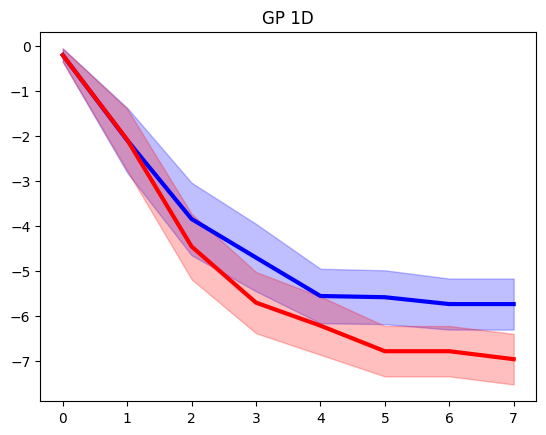

In [36]:
N = 20

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)


plt.title('GP 1D')  # LBSB

# PO GP

In [106]:
N = 20
total_record_PO_LBGS = []

for exp in range(N):

  print(exp)
  np.random.seed(exp)

  function = GP_ObjectiveFunction(dim=2,seed=exp)
  bounds=function.bounds
  dim = bounds.shape[0]
  fstar = max(function.max,Check_Max_byEI(function,seed=exp))
  print(fstar)
  fstar_belief = fstar

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim))
  train_obj = function(train_x)  #shape (n,)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  regret_holder = []
  regret_holder.append(fstar - float(train_obj.max()))

  iter_num = 8*dim

  research_length = 6. # By my experiment, a smaller research_length is better

  lengthscale = function.lengthscale
  variance = function.variance


  for iter in range(iter_num):

    print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    new_point_analytic = PO_acquisition_opt(model,bounds=bounds,fstar=fstar_belief,research_length=research_length,train_x=train_x,train_obj=train_obj) 
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(new_point_analytic).reshape(-1,1)   #.unsqueeze(-1) .to(device)


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

    regret = fstar - best_value
    regret_holder.append(regret)

  regret_holder = np.array(regret_holder)
  total_record_PO_LBGS.append(regret_holder)

0
8.178843762039094
0


 /home/hanyang/anaconda3/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


KeyboardInterrupt: 

Text(0.5, 1.0, 'GP 2D')

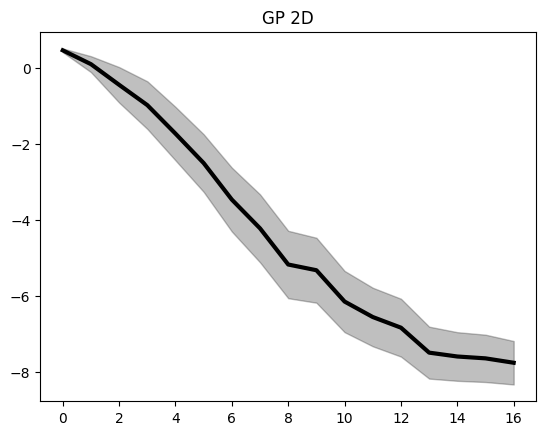

In [103]:
N = 20

# total_record = np.array(total_record_EI)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='blue')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

# total_record = np.array(total_record_MES)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='red')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO) #search range is 6
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('GP 2D')  # use nelder for all three

Text(0.5, 1.0, 'GP 1D')

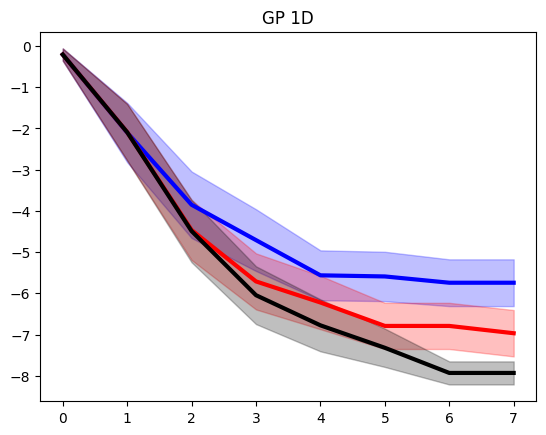

In [80]:
N = 20

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO) #search range is 6
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('GP 1D')  # use nelder for all three

Text(0.5, 1.0, 'GP 1D')

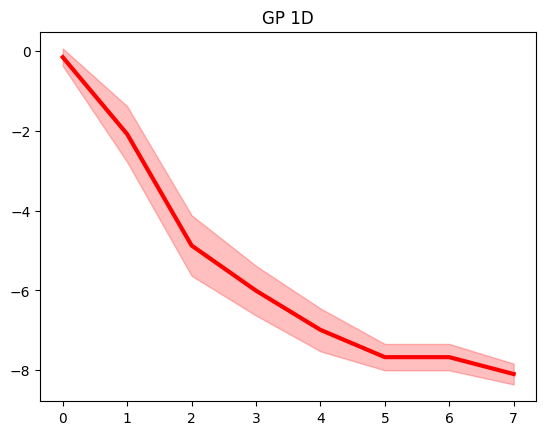

In [102]:
N = 20


total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)



plt.title('GP 1D')  # use nelder for all three

# Mixed GP

In [78]:
N = 20
total_record_Mixed = []

for exp in range(N):

  print(exp)
  np.random.seed(exp)

  function = GP_ObjectiveFunction(dim=2,seed=exp)
  bounds=function.bounds
  dim = bounds.shape[0]
  fstar = max(function.max,Check_Max_byEI(function,seed=exp))
  print(fstar)
  fstar_belief = fstar

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3*dim,dim))
  train_obj = function(train_x)  #shape (n,)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  regret_holder = []
  regret_holder.append(fstar - float(train_obj.max()))

  iter_num = 7*dim

  research_length = 6 # By my experiment, a smaller research_length is better

  lengthscale = function.lengthscale
  variance = function.variance


  for iter in range(iter_num):

    print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),train_obj.reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)
    
    new_point_analytic = Grid_Mixed_acquisition_opt(model,bounds=bounds,fstar=fstar_belief,research_length=research_length,train_x=train_x,train_obj=train_obj) 
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(new_point_analytic).reshape(-1,1)   #.unsqueeze(-1) .to(device)


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)

    regret = fstar - best_value
    regret_holder.append(regret)

  regret_holder = np.array(regret_holder)
  total_record_Mixed.append(regret_holder)

0
8.178843762039094
0


 /home/hanyang/anaconda3/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


1
2


KeyboardInterrupt: 

Text(0.5, 1.0, 'GP 2D')

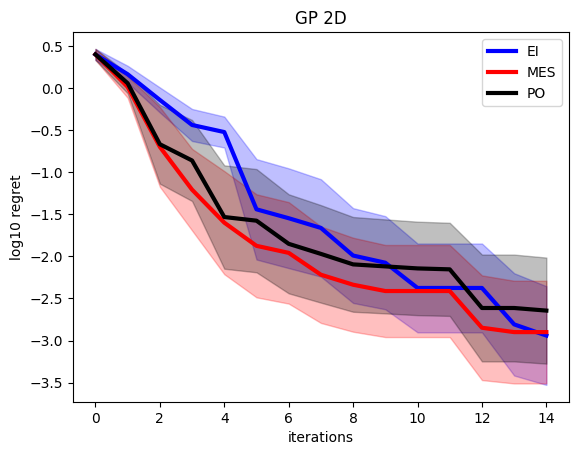

In [85]:
N = 20

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label='EI')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red',label='MES')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black',label='PO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

# total_record = np.array(total_record_Mixed)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='green',label='Mixed')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.ylabel('log10 regret')
plt.xlabel('iterations')
plt.legend()
plt.title('GP 2D')  # Grid search

Text(0.5, 1.0, 'GP 2D')

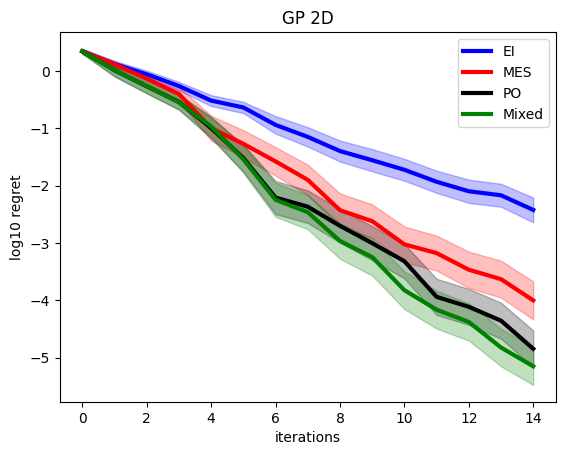

In [61]:
N = 100

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label='EI')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red',label='MES')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black',label='PO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

total_record = np.array(total_record_Mixed)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='green',label='Mixed')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.ylabel('log10 regret')
plt.xlabel('iterations')
plt.legend()
plt.title('GP 2D')  # use LGBS for all three

In [63]:
np.savetxt('debug_data/GP2d_EI', np.array(total_record_EI), delimiter=' ')
np.savetxt('debug_data/GP2d_MES', np.array(total_record_MES), delimiter=' ')
np.savetxt('debug_data/GP2d_PO', np.array(total_record_PO), delimiter=' ')
np.savetxt('debug_data/GP2d_Mixed', np.array(total_record_Mixed), delimiter=' ')

Text(0.5, 1.0, 'GP 1D')

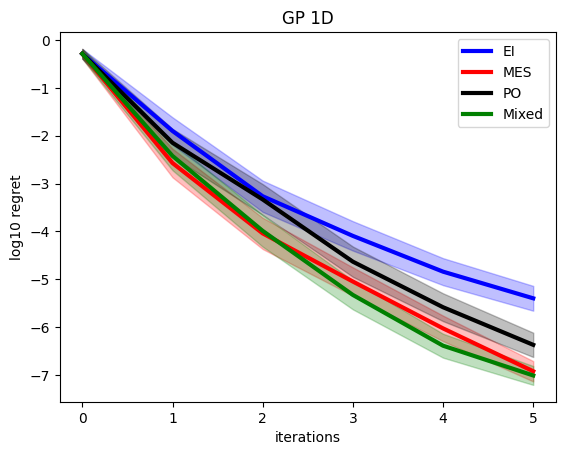

In [53]:
N = 100

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label='EI')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red',label='MES')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black',label='PO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

total_record = np.array(total_record_Mixed)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='green',label='Mixed')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.ylabel('log10 regret')
plt.xlabel('iterations')
plt.legend()
plt.title('GP 1D')  # use LGBS for all three

Text(0.5, 1.0, 'GP 2D')

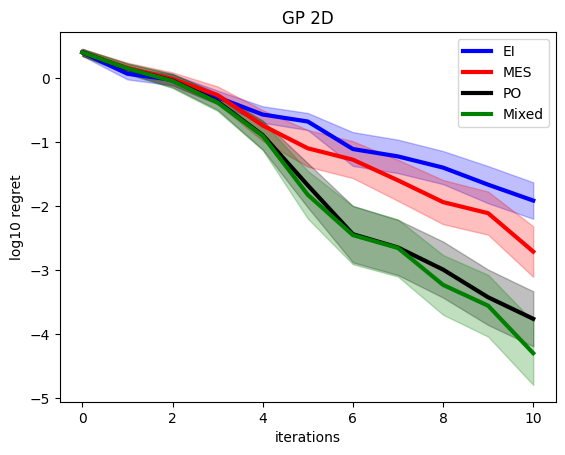

In [46]:
N = 50

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label='EI')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red',label='MES')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black',label='PO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

total_record = np.array(total_record_Mixed)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='green',label='Mixed')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.ylabel('log10 regret')
plt.xlabel('iterations')
plt.legend()
plt.title('GP 2D')  # use LGBS for all three

Text(0.5, 1.0, 'GP 2D')

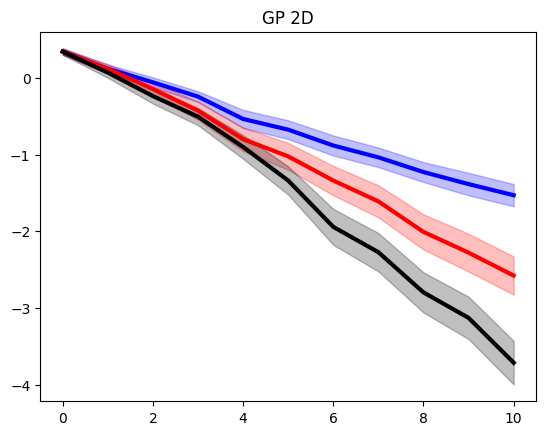

In [17]:
N = 100

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('GP 2D')  # use nelder for all three

Text(0.5, 1.0, 'GP 2D')

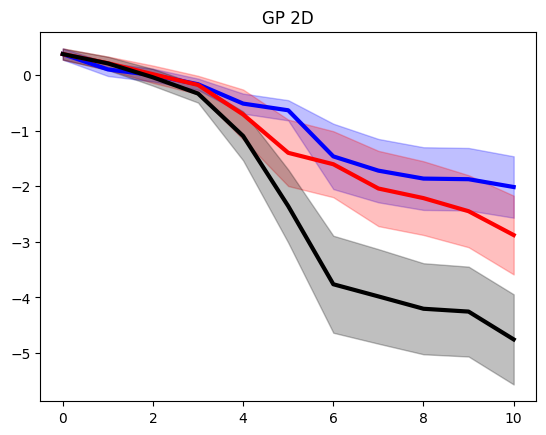

In [31]:
N = 20

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('GP 2D')  # use LGBS for all three

# 1d Plot

Text(0.5, 1.0, 'GP 1D (Grid)')

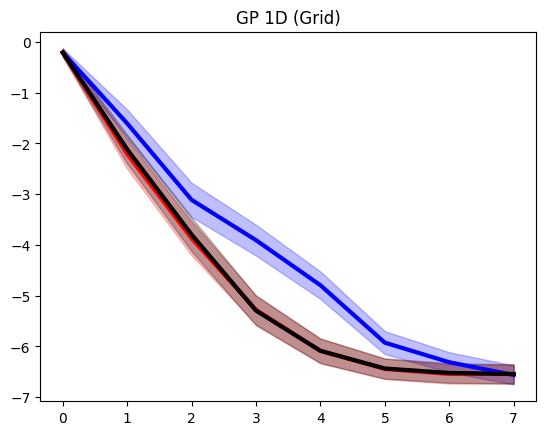

In [72]:
N = 100

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_Mixed) #search range is 6
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('GP 1D (Grid)')  # use nelder for all three

Text(0.5, 1.0, 'GP 1D (Grid)')

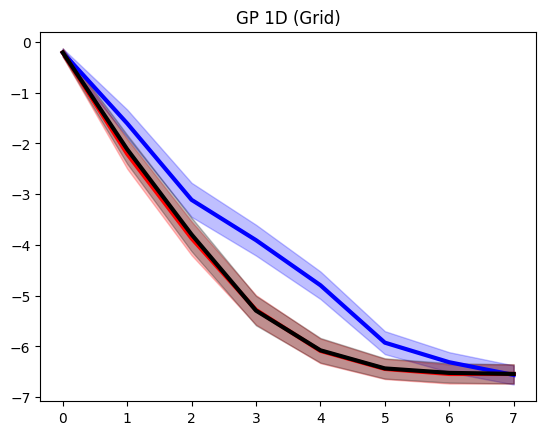

In [47]:
N = 100

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO) #search range is 6
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('GP 1D (Grid)')  # use nelder for all three

Text(0.5, 1.0, 'GP 1D (Grid)')

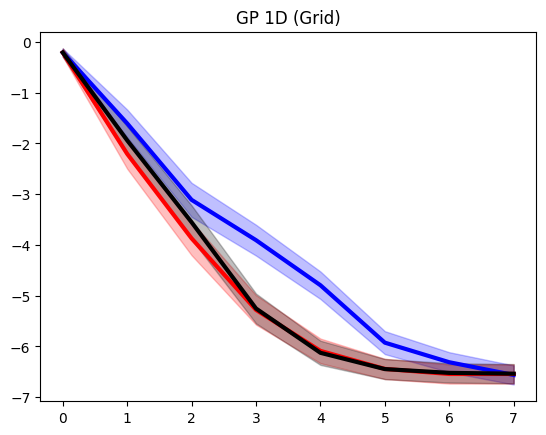

In [45]:
N = 100

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO) #search range is 1.5
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('GP 1D (Grid)')  # use nelder for all three

Text(0.5, 1.0, 'GP 1D')

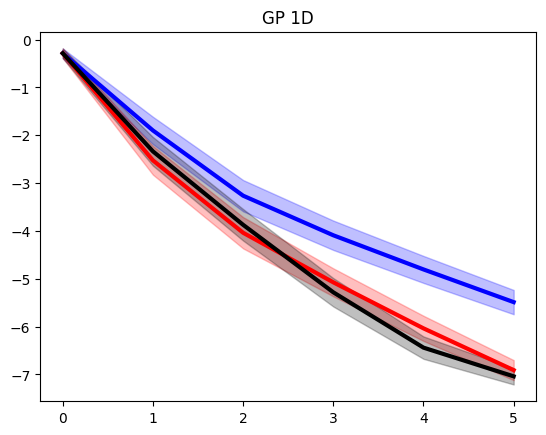

In [62]:
N = 100

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('GP 1D')  # use nelder for all three

Text(0.5, 1.0, 'GP 1D')

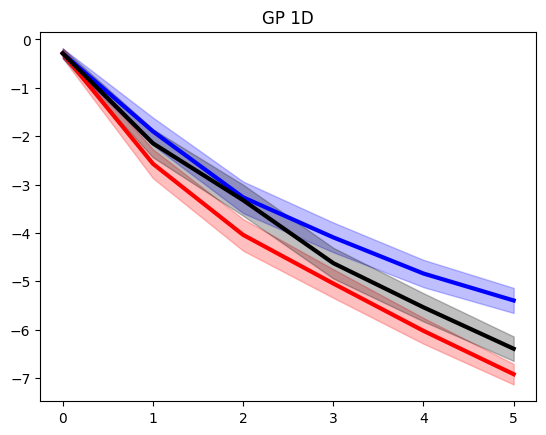

In [26]:
N = 100

total_record = np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('GP 1D')  # use LGBS for all three

# Branin

In [23]:
N = 10
total_record_EI = []

for exp in range(N):

  print(exp)
  np.random.seed(exp)

  function = Powell(dim=4,negate=True)
  bounds= np.array([[-4.,5.],[-4.,5.],[-4.,5.],[-4.,5.]])
  dim = bounds.shape[0]
  


  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3**dim,dim))
  train_obj = function(torch.tensor(train_x)).detach().numpy()  #shape (n,)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  iter_num = 50


  for iter in range(iter_num):

    #print(iter)
    
    obj_mean = np.mean(train_obj)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),(train_obj-obj_mean).reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)

    model.optimize()

    
    new_point_analytic = EI_acquisition_opt(model,bounds=bounds,f_best=best_value-obj_mean)
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(torch.tensor(new_point_analytic)).detach().numpy().reshape(-1,1)   


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)


  best_value_holder = np.array(best_value_holder)
  total_record_EI.append(best_value_holder)

0
1
2
3
4
5
6
7
8
9


In [24]:
N = 10
total_record_MES = []

fstar_belief = 0.

for exp in range(N):

  print(exp)
  np.random.seed(exp)
  
  function = Powell(dim=4,negate=True)
  bounds= np.array([[-4.,5.],[-4.,5.],[-4.,5.],[-4.,5.]])
  dim = bounds.shape[0]
  


  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3**dim,dim))
  train_obj = function(torch.tensor(train_x)).detach().numpy()  #shape (n,)

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  iter_num = 50


  for iter in range(iter_num):

    #print(iter)
    
    obj_mean = np.mean(train_obj)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)

    kernel = GPy.kern.RBF(input_dim=dim)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),(train_obj-obj_mean).reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)

    model.optimize()

    
    new_point_analytic = MES_acquisition_opt(model,bounds=bounds,fstar = fstar_belief-obj_mean)
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(torch.tensor(new_point_analytic)).detach().numpy().reshape(-1,1)   

    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)


  best_value_holder = np.array(best_value_holder)
  total_record_MES.append(best_value_holder)

0
1
2
3
4
5
6


 /tmp/ipykernel_4955/2559121661.py:13: RuntimeWarning:invalid value encountered in divide
 /tmp/ipykernel_4955/2559121661.py:13: RuntimeWarning:divide by zero encountered in log


7
8
9


 /tmp/ipykernel_4955/2559121661.py:13: RuntimeWarning:divide by zero encountered in divide
 /tmp/ipykernel_4955/2559121661.py:13: RuntimeWarning:invalid value encountered in subtract


In [148]:
N = 20
total_record_PO = []

fstar_belief = 39.166166*4

for exp in range(N):

  print(exp)
  np.random.seed(exp)
  
  function = StyblinskiTang(dim=4,negate=True)
  bounds= np.array([[-5.,5.],[-5.,5.],[-5.,5.],[-5.,5.]])
  dim = bounds.shape[0]
  
  
  research_length = (bounds[0][1]-bounds[0][0])/5

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3**dim,dim)) # for dim<=4, initial data is 3**dim. otherwise, 30*dim
  train_obj = function(torch.tensor(train_x)).detach().numpy()  #shape (n,)
  
  

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  iter_num = 50



  for iter in range(iter_num):

    print(iter)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),(train_obj).reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)

    model.optimize()

    
    new_point_analytic = PO_acquisition_opt(model,bounds=bounds,fstar=fstar_belief,research_length=research_length,train_x=train_x,train_obj=train_obj) 
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(torch.tensor(new_point_analytic)).detach().numpy().reshape(-1,1)   


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)


  best_value_holder = np.array(best_value_holder)
  total_record_PO.append(best_value_holder)

0
0
length of AF candidates are:  48
1
length of AF candidates are:  63
2
length of AF candidates are:  52
3
length of AF candidates are:  48
4
length of AF candidates are:  52
5
length of AF candidates are:  52
6
length of AF candidates are:  55
7
length of AF candidates are:  54
8
length of AF candidates are:  57
9
length of AF candidates are:  56
10
length of AF candidates are:  55
11
length of AF candidates are:  51
12
length of AF candidates are:  51
13
length of AF candidates are:  55
14
length of AF candidates are:  48
15
length of AF candidates are:  57
16
length of AF candidates are:  61
17
length of AF candidates are:  55
18
length of AF candidates are:  61
19
length of AF candidates are:  57
20
length of AF candidates are:  60
21
length of AF candidates are:  59
22
length of AF candidates are:  53
23
length of AF candidates are:  59
24
length of AF candidates are:  56
25
length of AF candidates are:  61
26
length of AF candidates are:  59
27
length of AF candidates are:  62


In [43]:
N = 20
total_record_Mixed = []

fstar_belief = 0.

for exp in range(N):

  print(exp)
  np.random.seed(exp)
  
  function = Griewank(dim=2, negate=True)
  bounds= np.array([[-5.,5.],[-5.,5.]])
  dim = bounds.shape[0]
  
  research_length = (bounds[0][1]-bounds[0][0])/5

  train_x = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(3**dim,dim))
  train_obj = function(torch.tensor(train_x)).detach().numpy()  #shape (n,)
  
  

  best_value_holder = []
  best_value_holder.append(float(train_obj.max()))

  iter_num = 10*dim



  for iter in range(iter_num):

    print(iter)
    
    # obj_mean = np.mean(train_obj)
    # obj_std = np.std(train_obj)

    best_value = best_value_holder[-1]

    train_x = train_x.reshape(-1,dim)
    train_obj = train_obj.reshape(-1,1)


    kernel = GPy.kern.RBF(input_dim=dim)
    model = GPy.models.GPRegression(train_x.reshape(-1,dim),(train_obj).reshape(-1,1),kernel)
    model.Gaussian_noise.variance.fix(0.0)

    model.optimize()

    
    new_point_analytic = Mixed_acquisition_opt(model,bounds=bounds,fstar=fstar_belief,research_length=research_length,train_x=train_x,train_obj=train_obj) 
    new_point_analytic = new_point_analytic.reshape(-1,dim)
    #print(new_point_analytic)

    new_obj = function(torch.tensor(new_point_analytic)).detach().numpy().reshape(-1,1)   


    train_x = np.concatenate((train_x, new_point_analytic))
    train_obj = np.concatenate((train_obj, new_obj))

    best_value = float(train_obj.max())
    best_value_holder.append(best_value)


  best_value_holder = np.array(best_value_holder)
  total_record_Mixed.append(best_value_holder)

0
0
length of AF candidates are:  13
1
length of AF candidates are:  9
2
length of AF candidates are:  14
3
length of AF candidates are:  17
4
length of AF candidates are:  11
5
length of AF candidates are:  18
6
length of AF candidates are:  26
7
length of AF candidates are:  18
8
length of AF candidates are:  22
9
length of AF candidates are:  25
10
length of AF candidates are:  21
11
length of AF candidates are:  25
12
length of AF candidates are:  24
13
length of AF candidates are:  26
14
length of AF candidates are:  25
15
length of AF candidates are:  24
16
length of AF candidates are:  28
17
length of AF candidates are:  25
18
length of AF candidates are:  28
19
length of AF candidates are:  24
1
0
length of AF candidates are:  10
1
length of AF candidates are:  10
2
length of AF candidates are:  10
3
length of AF candidates are:  10
4
length of AF candidates are:  6
5
length of AF candidates are:  7
6
length of AF candidates are:  11
7
length of AF candidates are:  10
8
length 

Text(0.5, 1.0, 'StyblinskiTang (5d)')

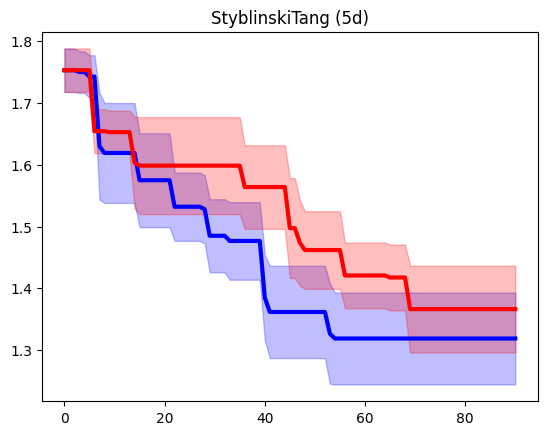

In [93]:
N = 4

fstar = 39.166166*5

total_record = (fstar-np.array(total_record_EI) )[:4,:]
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = (fstar-np.array(total_record_MES))[:4,:]
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

# total_record = fstar-np.array(total_record_Mixed)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.title('StyblinskiTang (5d)')  # use nelder for all three

Text(0.5, 1.0, 'StyblinskiTang (4d)')

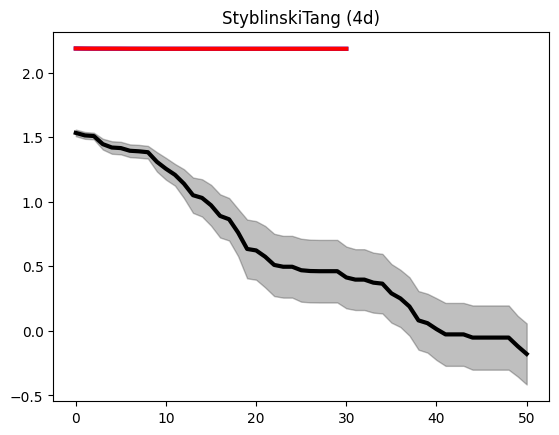

In [149]:
N = 20

fstar = 39.166166*4

total_record = (fstar-np.array(total_record_EI) )
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = (fstar-np.array(total_record_MES))
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

# total_record = fstar-np.array(total_record_Mixed)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.title('StyblinskiTang (4d)')  # use nelder for all three

In [150]:
np.savetxt('debug_data/StyblinskiTang4d_PO', np.array(total_record_PO), delimiter=' ')

In [139]:
np.savetxt('debug_data/StyblinskiTang4d_EI', np.array(total_record_EI), delimiter=' ')
np.savetxt('debug_data/StyblinskiTang4d_MES', np.array(total_record_MES), delimiter=' ')

In [140]:
(fstar-np.array(total_record_EI))[:5,:].shape

(5, 61)

Text(0.5, 1.0, 'StyblinskiTang 2d')

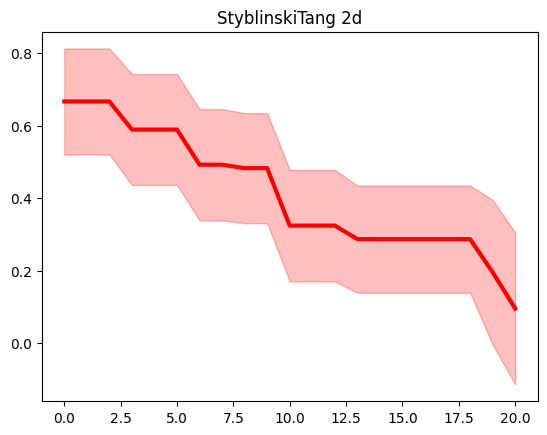

In [101]:
N = 20

fstar = 39.166166*2

# total_record = fstar-np.array(total_record_EI)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='blue')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

# total_record = fstar-np.array(total_record_PO)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='black')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

# total_record = fstar-np.array(total_record_Mixed)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.title('StyblinskiTang 2d')  # use nelder for all three

Text(0.5, 1.0, 'Rosenbrock')

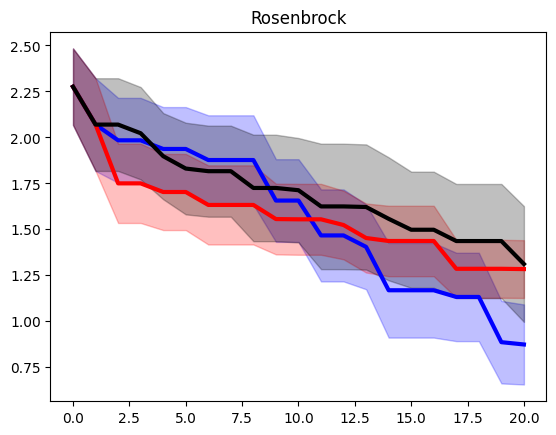

In [26]:
N = 10

fstar = 0.

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

# total_record = fstar-np.array(total_record_Mixed)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.title('Rosenbrock')  # use nelder for all three

Text(0.5, 1.0, 'SHEKEL (m=5)')

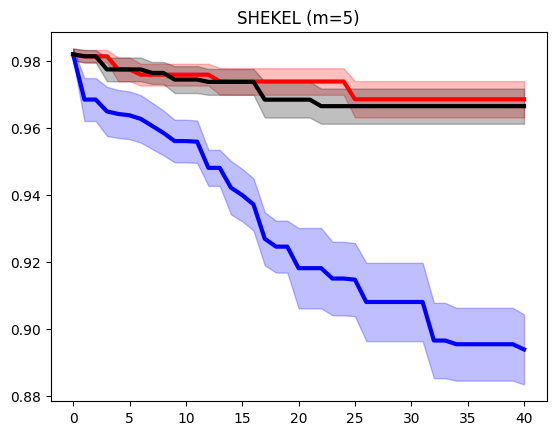

In [19]:
N = 10

fstar = 10.1532

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

# total_record = fstar-np.array(total_record_Mixed)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.title('SHEKEL (m=5)')  # use nelder for all three

Text(0.5, 1.0, 'Powell')

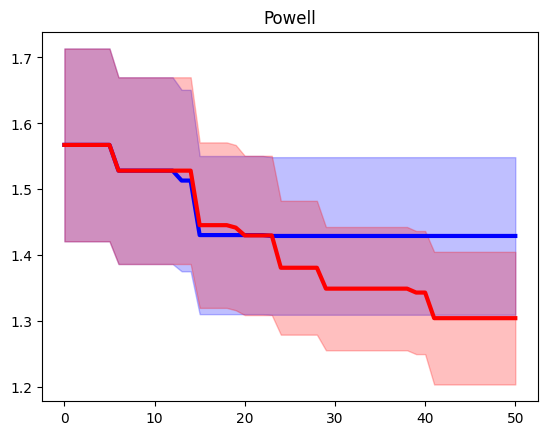

In [25]:
N = 10

fstar = 0.

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

# total_record = fstar-np.array(total_record_PO)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='black')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

# total_record = fstar-np.array(total_record_Mixed)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.title('Powell')  # use nelder for all three

Text(0.5, 1.0, 'Griewank')

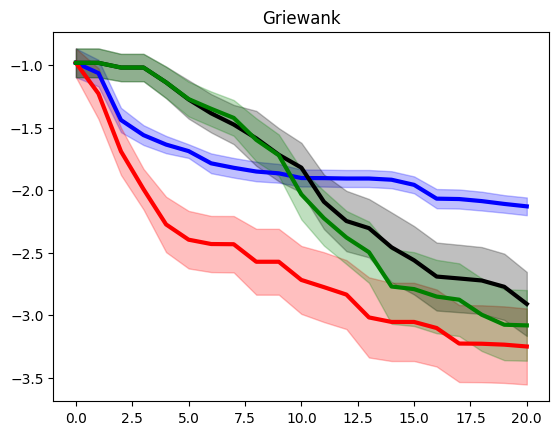

In [50]:
N = 20

fstar = 0.

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

total_record = fstar-np.array(total_record_Mixed)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.title('Griewank')  # use nelder for all three

Text(0.5, 1.0, 'Hartman ')

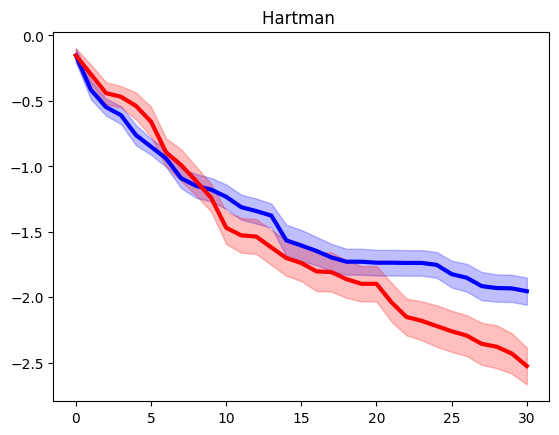

In [142]:
N = 20

fstar = 3.86278

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

# total_record = fstar-np.array(total_record_PO)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='black')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

# total_record = fstar-np.array(total_record_Mixed)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.title('Hartman ')  # use nelder for all three

In [143]:
np.savetxt('debug_data/Hartmann_EI', np.array(total_record_EI), delimiter=' ')
np.savetxt('debug_data/Hartmann_MES', np.array(total_record_MES), delimiter=' ')

Text(0.5, 1.0, 'Levy')

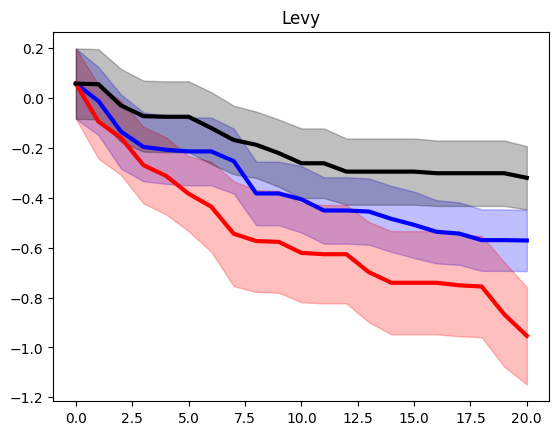

In [117]:
N = 20

fstar = 0.

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

# total_record = fstar-np.array(total_record_Mixed)
# total_record[total_record<=0]=10**(-9)
# total_record = np.log10(total_record)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='green',alpha=0.25)

plt.title('Levy')  # use nelder for all three

In [39]:
np.savetxt('debug_data/StyblinskiTang4d_EI', np.array(total_record_EI), delimiter=' ')
np.savetxt('debug_data/StyblinskiTang4d_MES', np.array(total_record_MES), delimiter=' ')
np.savetxt('debug_data/StyblinskiTang4d_PO', temp_data, delimiter=' ')
#np.savetxt('debug_data/Griewank_Mixed', np.array(total_record_Mixed), delimiter=' ')

In [33]:
np.savetxt('debug_data/Hartmann_Mixed', np.array(total_record_Mixed), delimiter=' ')

Text(0.5, 1.0, 'Beale')

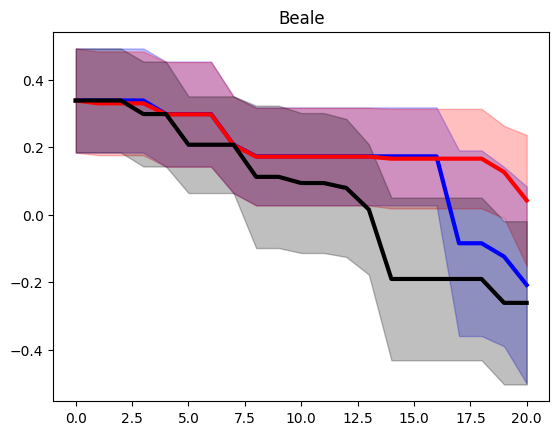

In [40]:
N = 10

fstar = 0.

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('Beale')  # use nelder for all three

Text(0.5, 1.0, 'Ackley')

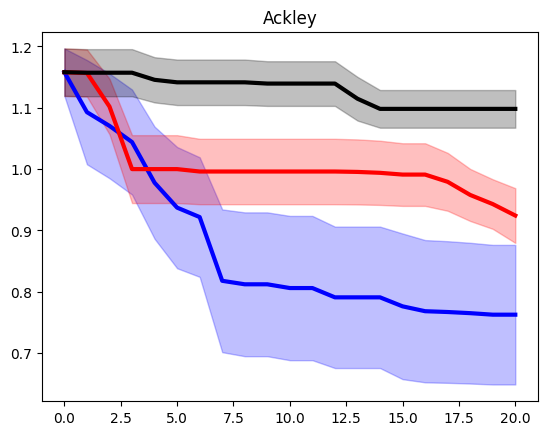

In [17]:
N = 10

fstar = 0.

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('Ackley')  # use nelder for all three

Text(0.5, 1.0, 'Branin')

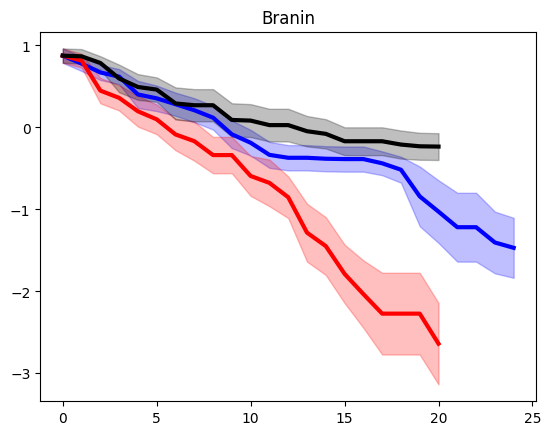

In [31]:
N = 12

fstar = -0.397887

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('Branin')  # use nelder for all three

Text(0.5, 1.0, 'Branin')

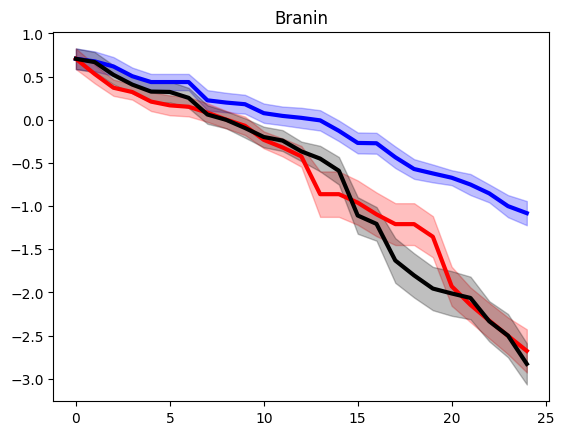

In [20]:
N = 20

fstar = -0.397887

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('Branin')  # use nelder for all three

Text(0.5, 1.0, 'Branin')

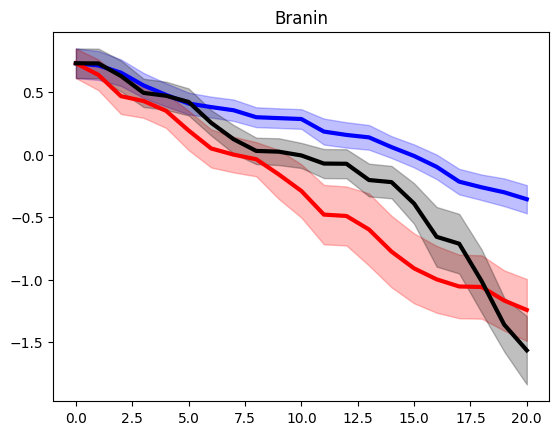

In [33]:
N = 20

fstar = -0.397887

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('Branin')  # use nelder for all three

Text(0.5, 1.0, 'Branin')

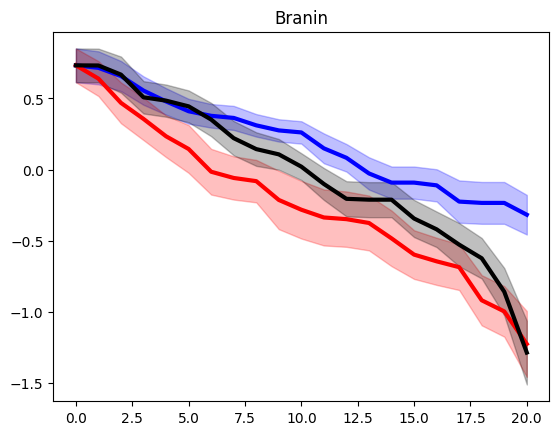

In [19]:
N = 20

fstar = -0.397887

total_record = fstar-np.array(total_record_EI)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

total_record = fstar-np.array(total_record_MES)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='red',alpha=0.25)

total_record = fstar-np.array(total_record_PO)
total_record[total_record<=0]=10**(-9)
total_record = np.log10(total_record)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='black',alpha=0.25)

plt.title('Branin')  # use LBGS for all three

# 1d other function